In [1]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

/home/maciej/Documents/Studia/Zima 2022/XAI/Project/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# UTILS

In [2]:
from PIL import Image

WIDTH = 256
HEIGHT = 256
# ROOT = "/home/kpusteln/melanoma/train/train/"
ROOT = '/home/maciej/Documents/Studia/Zima 2022/XAI/Project/archive/train/train'

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

In [3]:
def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

# END UTILS

In [4]:
#melanoma model
!wget -O model_melanoma "https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0"

--2022-12-02 18:39:23--  https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.72.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5gfs44hf282l22r/ckpt_epoch_18.pth [following]
--2022-12-02 18:39:24--  https://www.dropbox.com/s/raw/5gfs44hf282l22r/ckpt_epoch_18.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc163cabfe70de8bc66b3e01f31f.dl.dropboxusercontent.com/cd/0/inline/Bx1peHyDJtaFpO9rFsYzgmRV-w3sr624EVdEXKpTWtzchAi3wBSW0AjzUGy3y96gXGygRMCDllzXaezFiKDuiqshNqwv3Esy0k_U-fXXumrbzofYg2mhqNqZa-x_6qxNeQkEL7WVFdYPmu-AQhWXT8OveOQODeDpRTLHF4tjNLsUrA/file# [following]
--2022-12-02 18:39:24--  https://uc163cabfe70de8bc66b3e01f31f.dl.dropboxusercontent.com/cd/0/inline/Bx1peHyDJtaFpO9rFsYzgmRV-w3sr624EVdEXKpTWtzchAi3wBSW0AjzU

In [5]:
path_to_model = 'model_melanoma'

In [6]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)

In [7]:
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)

In [8]:
msg1

<All keys matched successfully>

In [9]:
test_tensor = torch.rand(1,3,224,224)

print(model(test_tensor)) # logits

tensor([[ 1.8564, -1.7918]], grad_fn=<AddmmBackward0>)


In [11]:
from melanoma.melanoma_loader import Melanoma_loader
from torchvision import transforms

dataset = Melanoma_loader(root = ROOT, ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [19]:
generator = iterate_class(dataset)

model = model.eval()

In [20]:
test_tensor, path = next(generator)

AttributeError: 'Melanoma_loader' object has no attribute 'lookup_path'

In [16]:
save_tesnor = test_tensor

In [17]:
t = transforms.Compose([transforms.CenterCrop(size = (180, 180)), transforms.Resize(256)])
test_tensor = t(test_tensor)

In [18]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)

# target = torch.eye(2)[[img[1]]] * out[0, 1]
target = torch.eye(2)[[1]]
# https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
from zennit.image import imgify
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

NameError: name 'path' is not defined

In [42]:
test_tensor = test_tensor.squeeze(0)
test_tensor = test_tensor.permute((1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


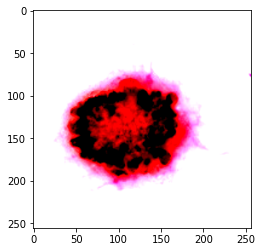

In [43]:
plt.imshow(test_tensor)

In [20]:
path

'ISIC_0030653'

In [21]:
# from zennit.composites import EpsilonPlusFlat
# from zennit.torchvision import ResNetCanonizer
# from zennit.attribution import Gradient

# # use the ResNet-specific canonizer
# canonizer = ResNetCanonizer()

# # create a composite, specifying the canonizers
# composite = EpsilonPlusFlat(canonizers=[canonizer])

# # choose a target class for the attribution (label 437 is lighthouse)
# target = torch.eye(2)[[img[1]]]
# # https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# # create the attributor, specifying model and composite
# with Gradient(model=model, composite=composite) as attributor:
#     # compute the model output and attribution
#     output, attribution = attributor(test_tensor, target)
    
# from zennit.image import imgify
# # sum over the channels
# relevance = attribution.sum(1)

# # create an image of the visualize attribution
# img = imgify(relevance, symmetric=True, cmap='coldnhot')
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

In [22]:

vgg_model = vgg16_bn(True).to(device)
vgg_model

NameError: name 'vgg16_bn' is not defined

In [23]:

from torchvision.models.resnet import resnet50

res_model = resnet50()
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
model = model.backbone

# CRP

In [48]:
try_tensor = torch.rand((1, 64, 128, 128))

In [49]:
out = model.layer1[0].conv1(try_tensor)
print(out[0, 0])
print(out[0, 1])

tensor([[-0.4809, -0.9993, -1.0548,  ..., -1.3739, -0.9226, -0.2615],
        [-0.5527, -1.6389, -1.3121,  ..., -0.9928, -0.7702, -1.5307],
        [-0.1783, -0.4760, -0.2425,  ..., -1.6284, -1.4354, -1.2476],
        ...,
        [-0.9315, -1.1479, -0.9606,  ..., -0.8288, -0.8421, -1.2095],
        [-0.3815, -0.1639, -0.0687,  ..., -1.3166, -0.9742, -0.4580],
        [-0.5760, -0.7537, -1.6980,  ..., -0.1548, -0.8971, -0.9887]])
tensor([[-1.3287, -1.6098, -1.2689,  ..., -1.4834, -1.1513, -1.3824],
        [-1.2505, -1.3668, -0.8084,  ..., -1.4884, -0.7578, -1.9731],
        [-1.4438, -1.0654, -1.5919,  ..., -0.9624, -1.4567, -1.5273],
        ...,
        [-0.9401, -1.2969, -1.4133,  ..., -1.7019, -1.8616, -1.0211],
        [-1.7928, -1.7955, -1.7551,  ..., -1.5184, -1.9607, -0.7249],
        [-1.4262, -1.9759, -1.4610,  ..., -1.0971, -1.6263, -1.5278]])


In [50]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"

#model = model.backbone
model.eval()


sample, path = next(generator)

In [54]:
!pip install zennit-crp

ERROR: Ignored the following versions that require a different python version: 0.4.1 Requires-Python >=3.8; 0.4.2 Requires-Python >=3.8; 0.4.3 Requires-Python >=3.8; 0.4.4 Requires-Python >=3.8; 0.5.0 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement zennit-crp (from versions: none)
ERROR: No matching distribution found for zennit-crp


In [55]:
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

cc = ChannelConcept()
attribution = CondAttribution(model)

ModuleNotFoundError: No module named 'crp'

In [27]:
itera = 0

False 7


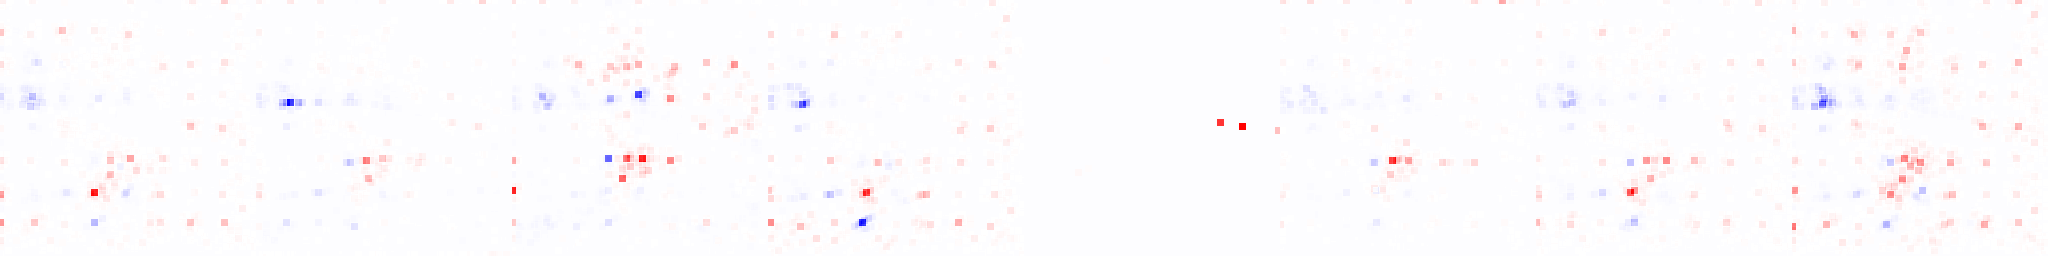

In [34]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(15, 33))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer1.0.conv1': [ids], 'y': [1]} for ids in concept_ids]
itera += 1
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map

heatmaps, _, _, _ = attribution(sample, conditions, composite)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

True 2


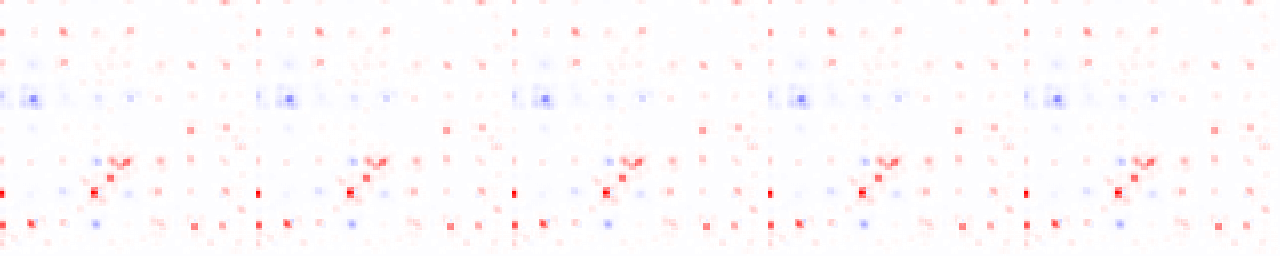

In [29]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(5))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer2.0.conv1': [ids], 'y': [1]} for ids in concept_ids]
itera += 1
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

heatmaps, _, _, _ = attribution(sample, conditions, composite, mask_map=mask_map)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

False 3


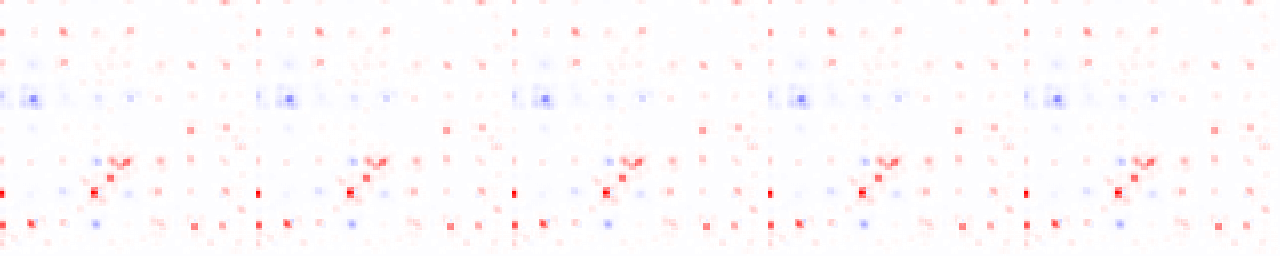

In [30]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(5))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer2.0.conv1': [ids], 'y': [1]} for ids in concept_ids]
itera += 1
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

heatmaps, _, _, _ = attribution(sample, conditions, composite, mask_map=mask_map)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)